# Imports

In [401]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import SVR
from scipy.stats import *
from functions import *

%matplotlib notebook
%matplotlib inline
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load features

- load_train_meta(vals = False)
- load_features(vals = False)

In [398]:
# hierarchy:

# ML_Challenge
# -code (all codes should be executed inside this directory)
# ----Notebook.ipynb
# ----functions.py
# -data
# ----train_meta.csv
# ----test
# ---------1100 test reading csvs
# ----train
# ---------1100 train readings csvs
# ----All generated csvs pertaining to feature extraction


Xmeta = load_train_meta()

print("Shape of Xmeta:", Xmeta.shape)

Shape of Xmeta: (1100, 5)
Shape of Xwave (1100, 88)


# Cross Validation

In [438]:
n_folds = 5

#KFold
cv = KFold(n_splits=n_folds, shuffle=True, random_state = 2211597)

# Training

In [432]:
comp = store_comp_features(test=False, store=True)
hist = store_hist_features(test=False, store=True)

compressed_cols = comp.columns
histogram_cols = hist.columns

Xtrain = pd.concat([comp, hist], axis = 1)
Ytrain = Xmeta['label']

print('Shape of Xtrain:', Xtrain.shape)
print('Shape of Ytrain:', Ytrain.shape)

Wave 0 at index 0
Wave 0 at index 200
Wave 0 at index 400
Wave 0 at index 600
Wave 0 at index 800
Wave 0 at index 1000
Wave 1 at index 0
Wave 1 at index 200
Wave 1 at index 400
Wave 1 at index 600
Wave 1 at index 800
Wave 1 at index 1000
Wave 2 at index 0
Wave 2 at index 200
Wave 2 at index 400
Wave 2 at index 600
Wave 2 at index 800
Wave 2 at index 1000
Wave 3 at index 0
Wave 3 at index 200
Wave 3 at index 400
Wave 3 at index 600
Wave 3 at index 800
Wave 3 at index 1000
Wave 4 at index 0
Wave 4 at index 200
Wave 4 at index 400
Wave 4 at index 600
Wave 4 at index 800
Wave 4 at index 1000
Wave 5 at index 0
Wave 5 at index 200
Wave 5 at index 400
Wave 5 at index 600
Wave 5 at index 800
Wave 5 at index 1000
Wave 6 at index 0
Wave 6 at index 200
Wave 6 at index 400
Wave 6 at index 600
Wave 6 at index 800
Wave 6 at index 1000
Wave 7 at index 0
Wave 7 at index 200
Wave 7 at index 400
Wave 7 at index 600
Wave 7 at index 800
Wave 7 at index 1000
Wave 8 at index 0
Wave 8 at index 200
Wave 8 at 

In [433]:
preprocessing = ColumnTransformer(
    transformers=[
        ('hist_features', Pipeline([('normalizer', Normalizer())]), histogram_cols),
        ('compressed_features', Pipeline([('minmaxscaler', MinMaxScaler())]), compressed_cols),
    ])

feature_selection = Pipeline([('variancethreshold', VarianceThreshold()), ('selectkbest', SelectKBest())]) 

regressor = Pipeline([('reg', SVR())])

In [434]:
param_grid = {
    #SVR
    'feature_selection__selectkbest__k': [135, 140, 145],
    'regressor__reg__C': np.logspace(np.log(17.6), np.log(17.8), 3),
    'regressor__reg__epsilon': np.logspace(np.log(0.191), np.log(0.1912), 3)
}

In [439]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('regressor', regressor)])

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=6, cv=cv, scoring = mae_scorer, verbose=10, return_train_score=True)
gridsearch.fit(Xtrain, Ytrain)

results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print()

print('Best params:')
print(gridsearch.best_params_)

print()

print('Training MAE {}'.format(train_score))
print('Validation MAE: {}'.format(validation_score))

print()

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best params:
{'feature_selection__selectkbest__k': 140, 'regressor__reg__C': 737.732475869997, 'regressor__reg__epsilon': 0.02210640636522597}

Training MAE -0.11246883205103084
Validation MAE: -0.17213156338359642



In [437]:
gridsearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('hist_features',
                                                  Pipeline(steps=[('normalizer',
                                                                   Normalizer())]),
                                                  Index(['low_h0', 'low_h1', 'low_h2', 'low_h3', 'low_h4', 'low_h5', 'low_h6',
       'low_h7', 'low_h8', 'low_h9',
       ...
       'phase_acc_h1090', 'phase_acc_h1091', 'phase_acc_h1092',
       'phase_acc_h1093', 'phase_acc_h1094', 'phase_acc_h1095',
       'phase_acc_h10...
       'phase_acc_q_75', 'phase_acc_kurtosis', 'phase_acc_skewness',
       'phase_acc_H', 'phase_acc_C', 'phase_acc_rms_amplitude',
       'phase_acc_crest_factor'],
      dtype='object', length=170))])),
                ('feature_selection',
                 Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k=135))])),
                ('regressor',
                 Pipeline(steps=[('reg',
                                  SVR(C=757.178820057403,
                                      epsilon=0.022133058675455817))]))])

# Error Analysis

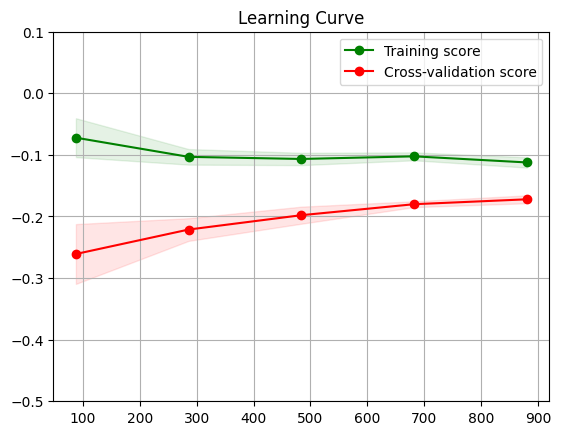

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


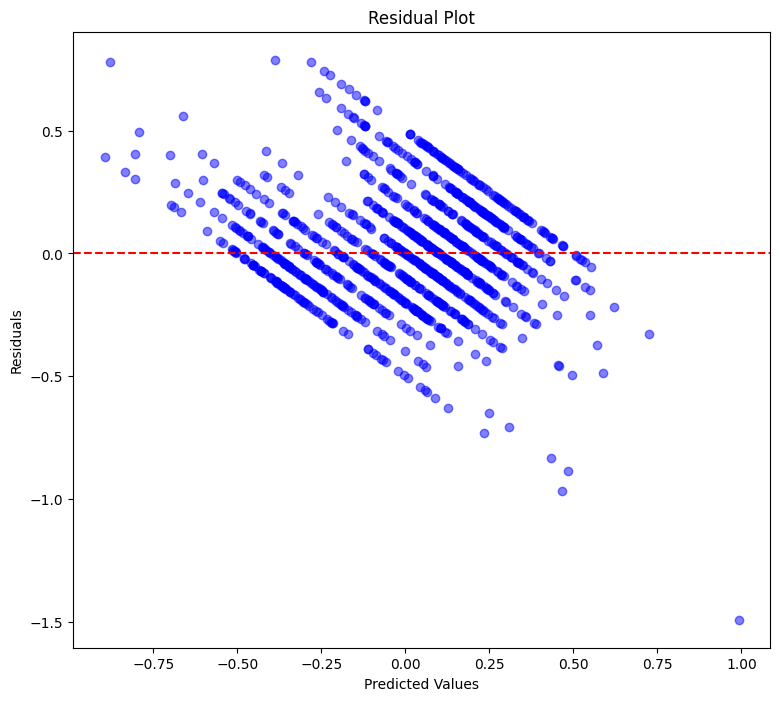

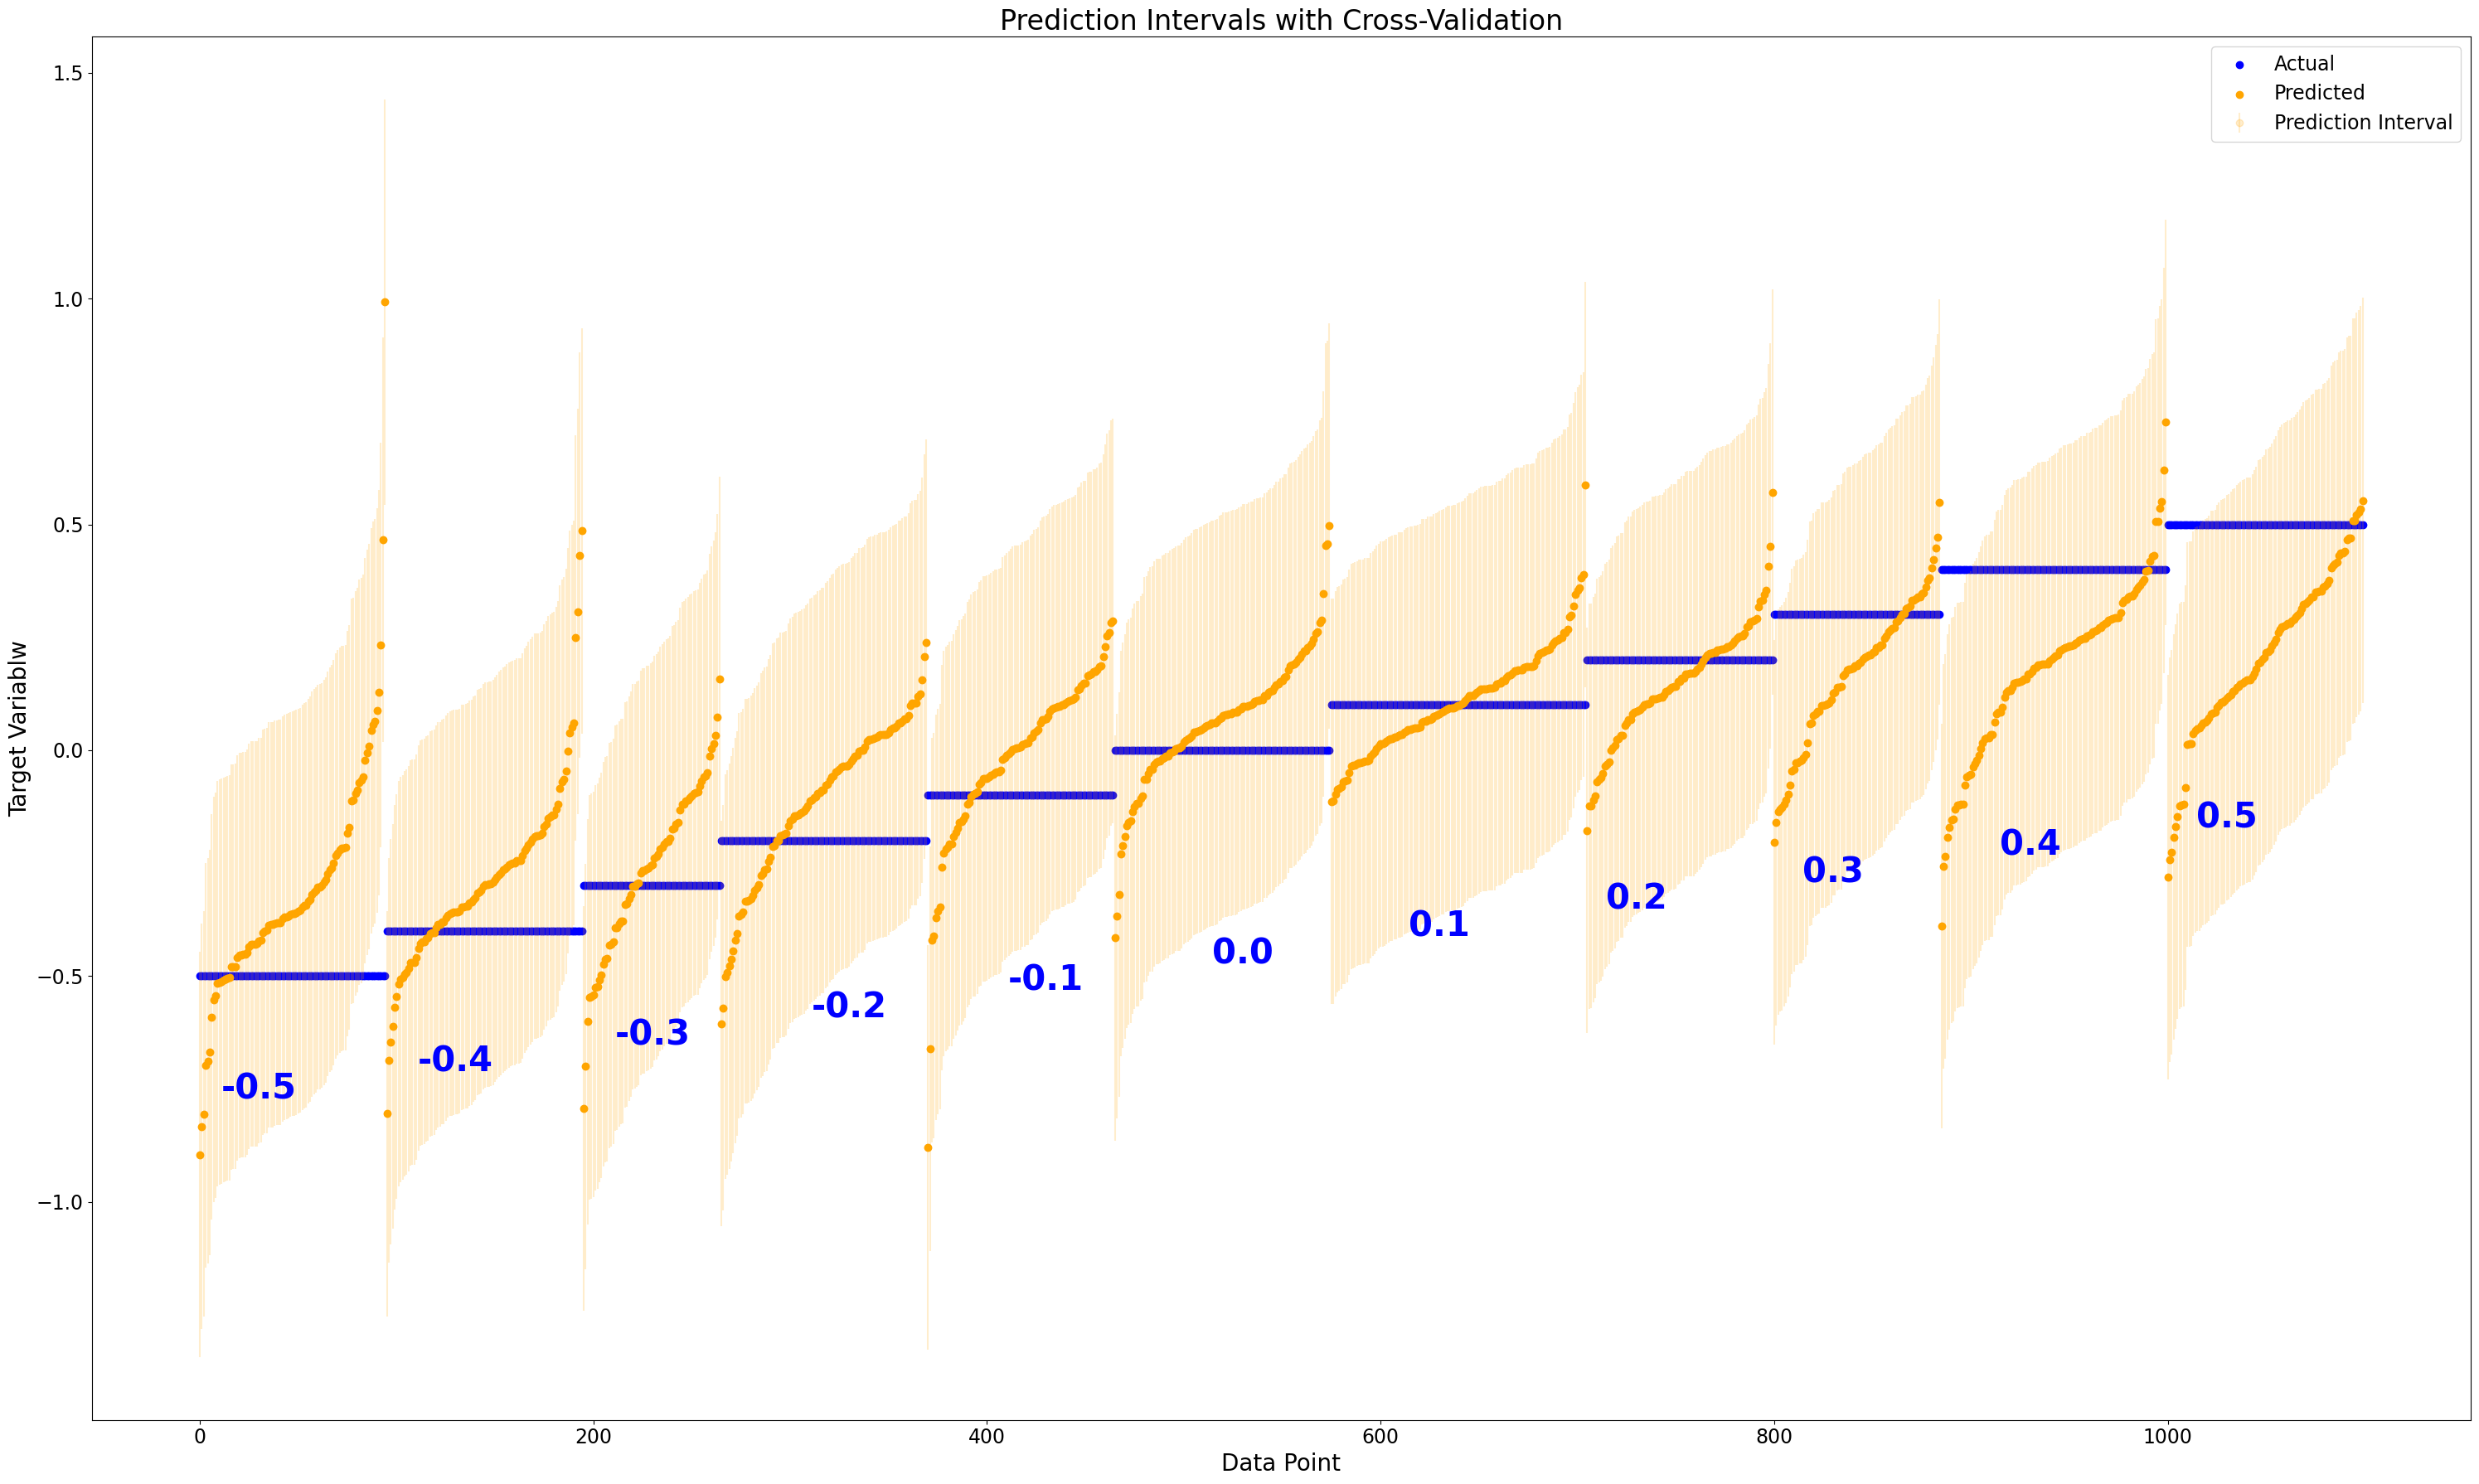

Cross-Validation Mean Absolute Error: 0.1721
Cross-Validation Mean Squared Error: 0.0524
Cross-Validation R-squared: 0.4621


In [417]:
regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)